In [1]:
import os
import torch 
import matplotlib.pyplot as plt

In [2]:
from torch_geometric.loader import DataLoader 
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='../datasets/Mutagenicity', name='Mutagenicity').shuffle()
print(len(dataset))
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)
print(len(train_dataset),len(test_dataset))

4337
3904 433


#### visualizing the data

In [3]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx


def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g


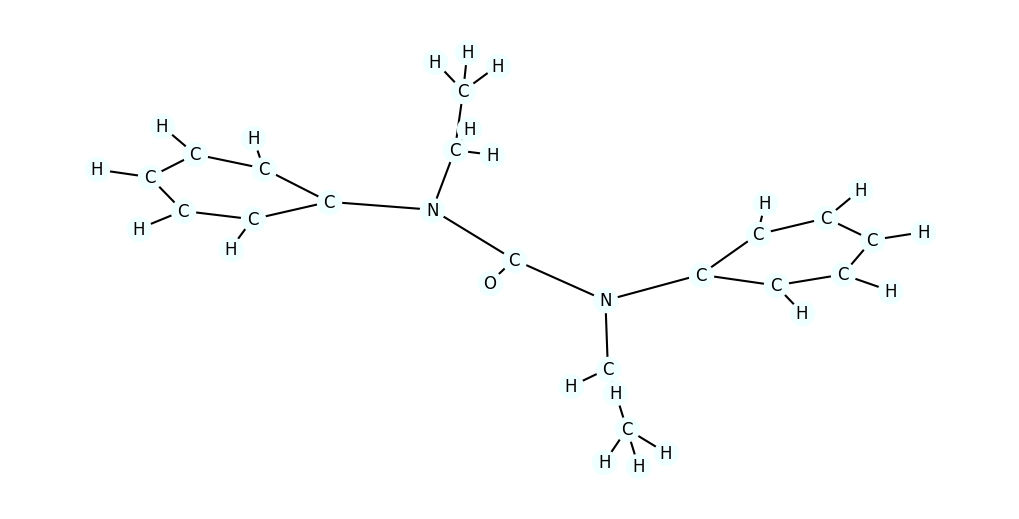

In [4]:
import random

data = random.choice([t for t in train_dataset])
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

#### training the model

In [5]:
import torch
from torch.nn import Linear 
import torch.nn.functional as F

from torch_geometric.nn import GraphConv, global_add_pool

class Net(torch.nn.Module):
    def __init__(self,dim):
        super(Net, self).__init__()

        num_features = dataset.num_features
        self.dim= dim

        self.conv1 = GraphConv(num_features,dim)
        self.conv2 = GraphConv(dim,dim)
        self.conv3 = GraphConv(dim,dim)
        self.conv4 = GraphConv(dim,dim)
        self.conv5 = GraphConv(dim,dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, dataset.num_classes)
    
    def forward(self,x,edge_index,batch,edge_weight=None):
        x = self.conv1(x,edge_index,edge_weight).relu()
        x = self.conv2(x,edge_index,edge_weight).relu()
        x = self.conv3(x,edge_index,edge_weight).relu()
        x = self.conv4(x,edge_index,edge_weight).relu()
        x = self.conv5(x,edge_index,edge_weight).relu()
        # batch-wise graph-level outputs by adding node features
        # across the node dimension
        x = global_add_pool(x,batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

#### define train and test functions

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# for i, param_group in enumerate(optimizer.param_groups):
#     print(f"Parameter Group {i+1}:")
#     for param in param_group['params']:
#         # Print the number of parameters in the group
#         print(f"Number of parameters: {len(param)}")
        
#         # Print the names of parameters
#         for name, p in model.named_parameters():
#             if p is param:
#                 print(f"Parameter Name: {name}")

In [7]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [8]:
for epoch in range(1,101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f},Train acc: {train_acc:.4f}, test acc: {test_acc:.4f}')

Epoch: 001, Loss: 0.7524,Train acc: 0.6542, test acc: 0.6328
Epoch: 002, Loss: 0.6377,Train acc: 0.6824, test acc: 0.6813
Epoch: 003, Loss: 0.6156,Train acc: 0.6998, test acc: 0.6928
Epoch: 004, Loss: 0.6000,Train acc: 0.7170, test acc: 0.7090
Epoch: 005, Loss: 0.5790,Train acc: 0.7526, test acc: 0.6859
Epoch: 006, Loss: 0.5513,Train acc: 0.7572, test acc: 0.7159
Epoch: 007, Loss: 0.5425,Train acc: 0.7720, test acc: 0.7483
Epoch: 008, Loss: 0.5360,Train acc: 0.7879, test acc: 0.7575
Epoch: 009, Loss: 0.5181,Train acc: 0.7772, test acc: 0.7413
Epoch: 010, Loss: 0.5196,Train acc: 0.7879, test acc: 0.7483
Epoch: 011, Loss: 0.5070,Train acc: 0.7951, test acc: 0.7691
Epoch: 012, Loss: 0.4998,Train acc: 0.8017, test acc: 0.7737
Epoch: 013, Loss: 0.5085,Train acc: 0.7979, test acc: 0.7506
Epoch: 014, Loss: 0.4967,Train acc: 0.8017, test acc: 0.7621
Epoch: 015, Loss: 0.4835,Train acc: 0.8128, test acc: 0.7760
Epoch: 016, Loss: 0.4857,Train acc: 0.8179, test acc: 0.7714
Epoch: 017, Loss: 0.4719

## Explaining the predictions via Captum library

- Model attribution: understanding how each individual input feature contributes to the final prediction by NN

- Methods for model attribution: Gradient-based method (gradient of output w.r.t input feastues), Integrated gradients (integrates the gradients of the output w.r.t the input features along a path from a baseline to the actual input)

In [9]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

c:\Users\dpa13\AppData\Local\miniforge3\envs\gnn_mol\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


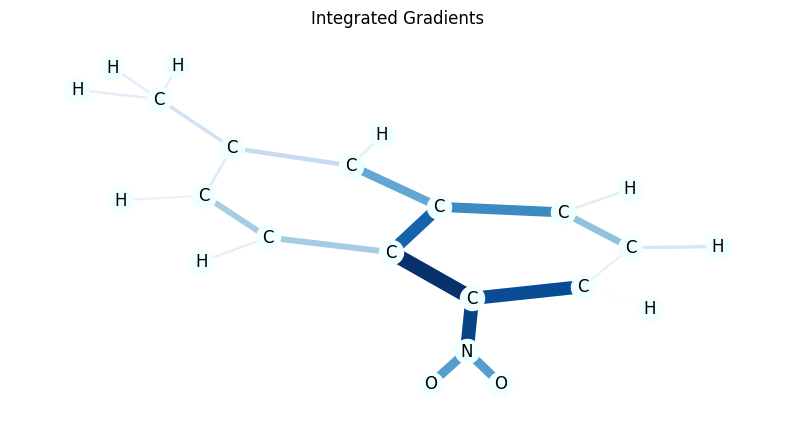

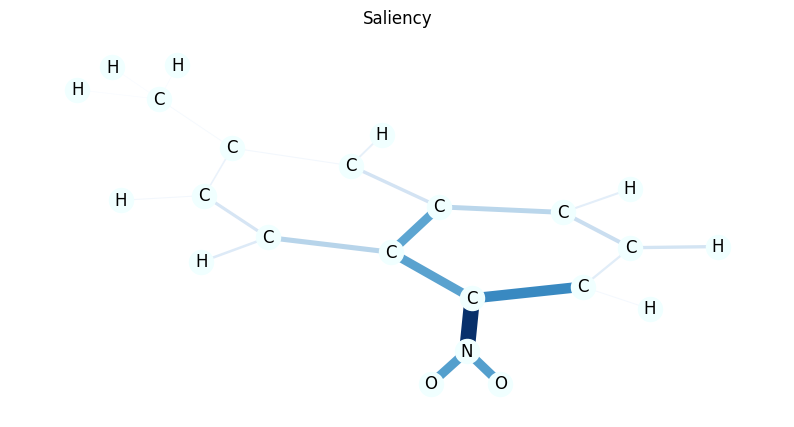

In [10]:
import random
from collections import defaultdict

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict
    
# mode the data to device as 'input_mask' is moved to device in explain function
data = random.choice([t for t in test_dataset if not t.y.item()]).to('cuda:0')
mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)